In [11]:
import os
import pandas as pd
import pathlib

curr_path = os.path.abspath('..')
folder_path = os.path.join(curr_path, 'Datasets\\newsela_article_corpus_2016-01-29')
data_path = os.path.join(folder_path, 'articles_metadata.csv')
stopwords_path = os.path.join(curr_path, 'DataExploration','newsela_stopwords.txt')
newsela = pd.read_csv(data_path)

with open(stopwords_path, 'r') as f:
    stopwords = f.read().split()

In [13]:
# Or, Loading dataset with metrics

data_path = os.path.join(folder_path, 'articles_metadata.csv')
newsela = pd.read_csv(data_path)

# Newsela Dataset (Spanish) Readability Baselines

Flesch-Kincaid Grade Level: Scores text at a U.S grade level.  Uses word counts, sentence counts and syllable counts.
When the number is great than 10, is the number of years required to understand the text.  Expectation: Harder the text, larger the number.  No upper bound, lowerbound -3.4 per Wikipedia.  

Flesch Reading Ease: Scale between 1 to 100 on readability (translates directly to predefined schol levels).  Higher the number, easier the text to read.  The lower the number, the more difficult.  Expectation:Harder the text, lower the number.  Upper Bound: 121.22, No theoretical lower bound.

Automated Readability Index (ARI): Uses. characters per word, word counts, sentence counts, lower bound 1 (?), no upper bound

## Calculating Heuristic Scores

In [19]:
import numpy as np
from textstat import flesch_reading_ease, flesch_kincaid_grade, automated_readability_index
import re

def get_text(filename, dp):
    fp = os.path.join(dp, 'articles', filename)
    with open(fp, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Keep only english
newsela_es = newsela[newsela['language'] == 'es']
newsela_es['f_grade'] = newsela_es['filename'].apply(lambda x: flesch_kincaid_grade(get_text(x, folder_path)))
newsela_es['f_ease'] = newsela_es['filename'].apply(lambda x: flesch_reading_ease(get_text(x, folder_path)))
newsela_es['ari'] = newsela_es['filename'].apply(lambda x: automated_readability_index(get_text(x, folder_path)))

c:\users\jchle\work\nrc_research\rankread\windows_venv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


## Calculating statistics and visualizations

In [20]:
metric_stats = newsela_es.groupby('grade_level')[['f_grade', 'f_ease', 'ari']].agg(['min', 'max', 'mean','std'])
metric_stats

f_grade                               f_ease                    \
                min    max       mean        std     min    max       mean   
grade_level                                                                  
2.0             5.0   21.8   7.683051   2.352120   17.85  83.15  64.967119   
3.0             6.1   12.7   8.772414   1.441412   43.63  75.00  61.245259   
4.0             7.1   22.0  10.716149   1.849929   17.44  72.46  54.260373   
5.0             8.8   23.6  13.155479   2.090373   24.01  64.14  47.392671   
6.0            10.7   23.6  16.214159   2.698507   18.70  57.71  37.798053   
7.0            11.4   34.7  19.029032   3.738375   -4.93  54.66  29.821161   
8.0            14.3   42.5  22.733043   4.456628  -30.64  42.75  19.559043   
9.0            13.8  100.7  26.183036   9.296041 -182.08  45.83   9.972143   
10.0           29.5   29.5  29.500000        NaN    3.17   3.17   3.170000   
12.0           14.2   94.6  31.561728  11.615243 -171.46  43.50  -3.759918   

                         ari                               
                   std   min    max       mean        std  
grade_level                                                
2.0           9.732503   5.5   25.2   9.132203   2.788180  
3.0           7.079137   7.0   15.9  10.318966   1.811889  
4.0           7.549888   7.7   25.2  12.381366   2.274676  
5.0           6.701169  10.3   29.7  15.408219   2.650010  
6.0           8.464077  12.8   29.1  19.103540   3.556280  
7.0          10.429776  12.1   43.6  22.765161   4.850928  
8.0          11.706838  16.6   52.5  27.320000   5.923462  
9.0          24.529897  15.0  128.5  31.822321  12.003286  
10.0               NaN  36.4   36.4  36.400000        NaN  
12.0         30.652913  16.2  119.3  38.500000  14.913120

Text(0.5, 0.98, 'Statistical Measures for Various Readability Assessment Metrics')

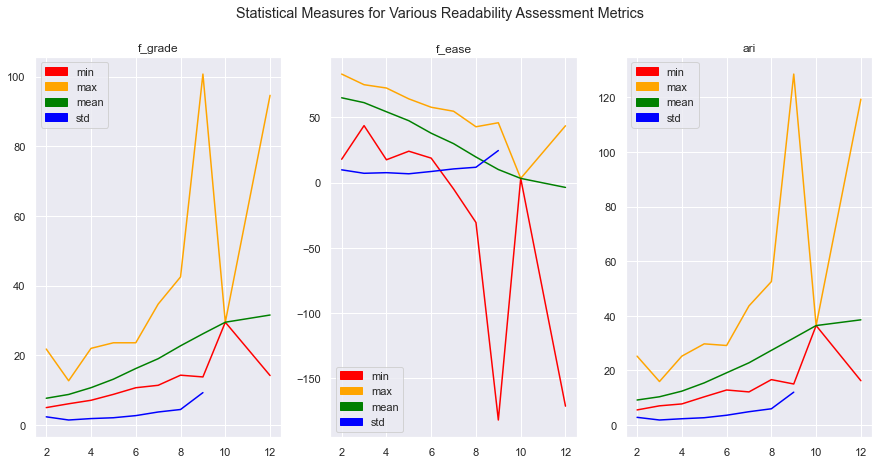

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['f_grade', 'f_ease', 'ari']

fig, axs = plt.subplots(1,3, figsize=(15, 7))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = metric_stats[s]
    score_stats.reset_index(inplace=True)
    patches = []
    
    for i in range(len(colors)):   
        axs[y_counter].plot(score_stats['grade_level'], score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[y_counter].legend(handles=patches)
    axs[y_counter].set_title(s)
    
    if y_counter == 2:
        y_counter = 0
        x_counter = 1
    else:
        y_counter += 1

fig.suptitle('Statistical Measures for Various Readability Assessment Metrics')

## Document Distributions Over Grade Levels

In [24]:
document_dists = newsela_es.groupby(['grade_level'])['grade_level'].agg(['count'])
document_dists

count
grade_level       
2.0             59
3.0            116
4.0            161
5.0            146
6.0            113
7.0            155
8.0            115
9.0            112
10.0             1
12.0           243

Text(0.5, 1.0, 'Document Distribution Over Grade Level')

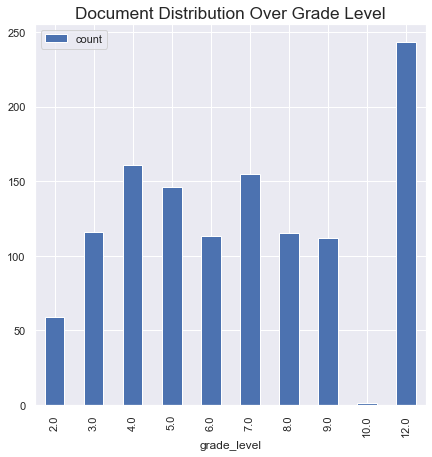

In [25]:
import matplotlib.pyplot as plt
ax = document_dists.plot.bar(y='count', use_index=True, figsize=(7,7))
ax.set_title("Document Distribution Over Grade Level", fontsize="x-large")

## N-Gram and Document Lengths

In [26]:
import numpy as np

newsela_es['avg_tokenlength'] = newsela_es['filename'].apply(lambda x: np.mean([len(w) for w in re.split('\.|\\n|\s', get_text(x, folder_path)) if w != ''])) 
newsela_es['documentlength_token'] = newsela_es['filename'].apply(lambda x: len([w for w in re.split('\.|\\n|\s', get_text(x, folder_path)) if w != '']))
newsela_es['documentlength_sentence'] = newsela_es['filename'].apply(lambda x: len([s for s in re.split('\.|\\n', get_text(x, folder_path)) if s != '']))
newsela_es['avg_sentencelength_char'] = newsela_es['filename'].apply(lambda x: np.mean([len(w) for w in re.split('\.|\\n', get_text(x, folder_path)) if w != '']))
newsela_es['avg_sentencelength_token'] = newsela_es['filename'].apply(lambda x: np.mean([len(w.split()) for w in re.split('\.|\\n', get_text(x, folder_path)) if w != '']))


c:\users\jchle\work\nrc_research\rankread\windows_venv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [27]:
length_stats = newsela_es.groupby('grade_level')[['documentlength_token',
                                               'documentlength_sentence',
                                               'avg_tokenlength', 
                                               'avg_sentencelength_char',
                                               'avg_sentencelength_token']].agg(['min', 'max', 'mean','std'])
length_stats

documentlength_token                                 \
                             min   max         mean         std   
grade_level                                                       
2.0                          212   674   327.932203   69.261589   
3.0                          242   966   389.896552   87.501292   
4.0                          344  1344   595.254658  103.918314   
5.0                          296  1466   671.273973  114.950515   
6.0                          500  1764   796.274336  174.779466   
7.0                          317  2065   863.316129  181.200461   
8.0                          504  2150   967.078261  206.495663   
9.0                          350  1247   924.026786  153.738602   
10.0                        1288  1288  1288.000000         NaN   
12.0                         328  3096  1183.477366  486.947248   

            documentlength_sentence                             \
                                min  max       mean        std   
grade_level                                                      
2.0                              25   53  41.338983   7.040793   
3.0                              23  111  42.232759  10.230694   
4.0                              29  129  53.925466  10.689102   
5.0                              20  115  50.945205  10.589377   
6.0                              29  117  52.123894  12.465046   
7.0                              19  115  50.374194  12.401900   
8.0                              29  101  51.000000  11.580383   
9.0                              17   85  43.651786   9.515005   
10.0                             58   58  58.000000        NaN   
12.0                             11  177  50.193416  23.865144   

            avg_tokenlength                                \
                        min       max      mean       std   
grade_level                                                 
2.0                4.351499  5.117347  4.741601  0.202700   
3.0                4.287599  5.337079  4.778719  0.224412   
4.0                4.348457  5.510870  4.843260  0.204386   
5.0                4.354059  5.392182  4.872317  0.180207   
6.0                4.514000  5.469863  4.941500  0.185070   
7.0                4.605392  5.443272  4.997900  0.171500   
8.0                4.577263  5.375921  5.005351  0.175684   
9.0                4.631414  5.554162  5.062841  0.182223   
10.0               5.003106  5.003106  5.003106       NaN   
12.0               4.486301  5.592152  5.032053  0.176588   

            avg_sentencelength_char                                     \
                                min         max        mean        std   
grade_level                                                              
2.0                       36.615385   87.304348   45.470788   7.483651   
3.0                       35.911111   68.809524   53.429190   5.178656   
4.0                       48.694118   91.640000   64.623998   6.450145   
5.0                       50.849315  101.921053   77.776732   7.177844   
6.0                       72.197183  110.461538   90.893372   7.462691   
7.0                       71.153846  133.263158  103.553100  10.131277   
8.0                       86.094595  133.057143  114.148247  10.323367   
9.0                       84.016129  168.250000  129.488505  13.501674   
10.0                     132.706897  132.706897  132.706897        NaN   
12.0                      81.731183  270.666667  147.678261  29.521026   

            avg_sentencelength_token                                  
                                 min        max       mean       std  
grade_level                                                           
2.0                         6.333333  14.652174   7.978246  1.241226  
3.0                         6.066667  11.896552   9.324390  0.966588  
4.0                         8.526316  15.380000  11.131678  1.082719  
5.0                         8.534247  16.878788  13.327310  1.258839  
6.0                        

Text(0.5, 0.98, 'Statistical Measures for Length Metrics')

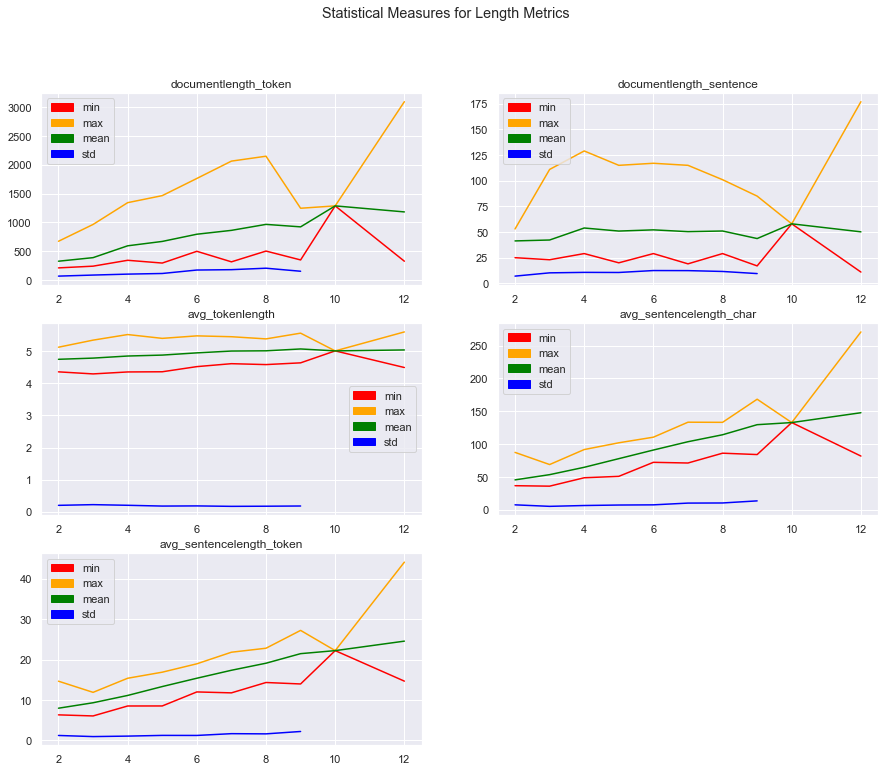

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['documentlength_token','documentlength_sentence','avg_tokenlength', 'avg_sentencelength_char', 'avg_sentencelength_token']

fig, axs = plt.subplots(3,2, figsize=(15, 12))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = length_stats[s]
    score_stats.reset_index(inplace=True)
    patches = []
    
    for i in range(len(colors)):   
        axs[x_counter, y_counter].plot(score_stats['grade_level'], score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[x_counter, y_counter].legend(handles=patches)
    axs[x_counter, y_counter].set_title(s)
    
    if y_counter == 1:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1
fig.delaxes(axs[2,1])
fig.suptitle('Statistical Measures for Length Metrics')

## N-Gram Analysis

c:\users\jchle\work\nrc_research\rankread\windows_venv\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ais', 'amos', 'bamos', 'estarã', 'estuviã', 'estã', 'fuã', 'habrã', 'habã', 'hayã', 'hubiã', 'mã', 'quã', 'ramos', 'semos', 'serã', 'seã', 'sã', 'tambiã', 'tendrã', 'tengã', 'tenã', 'tuviã', 'tãº'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


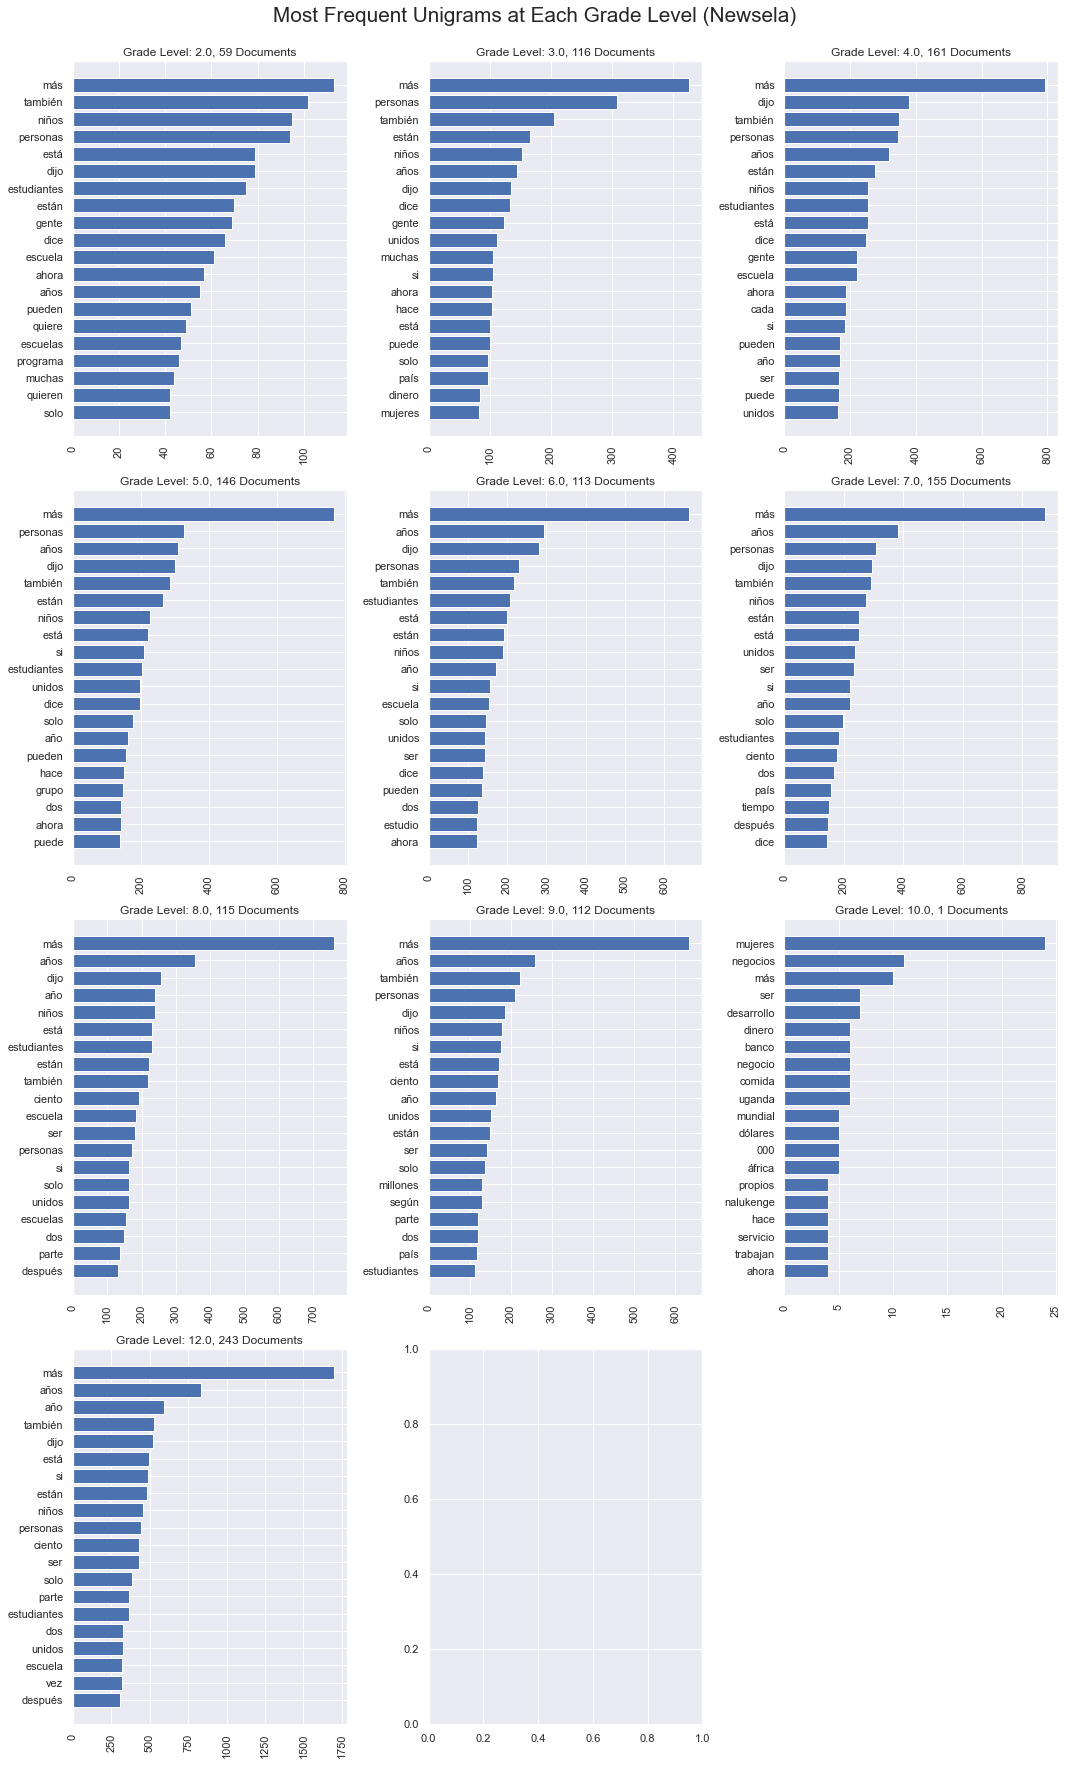

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(4,3, figsize=(15, 25))
x_counter = 0
y_counter = 0


levels = pd.unique(newsela_es['grade_level'].sort_values())

for lvl in levels:
    vectorizer = CountVectorizer(stop_words=stopwords)
    curr_level = newsela_es[newsela_es['grade_level'] == lvl]
    texts = curr_level['filename'].apply(lambda x: get_text(x, folder_path))
    counts = np.asarray(np.sum(vectorizer.fit_transform(texts), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[x_counter, y_counter].barh(keys[::-1], vals[::-1])
    axs[x_counter, y_counter].tick_params(axis='x', rotation=90)
    axs[x_counter, y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, curr_level.shape[0]))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Unigrams at Each Grade Level (Newsela)',fontsize='xx-large')
fig.delaxes(axs[3,2])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('freq_1gram_newsela.png')

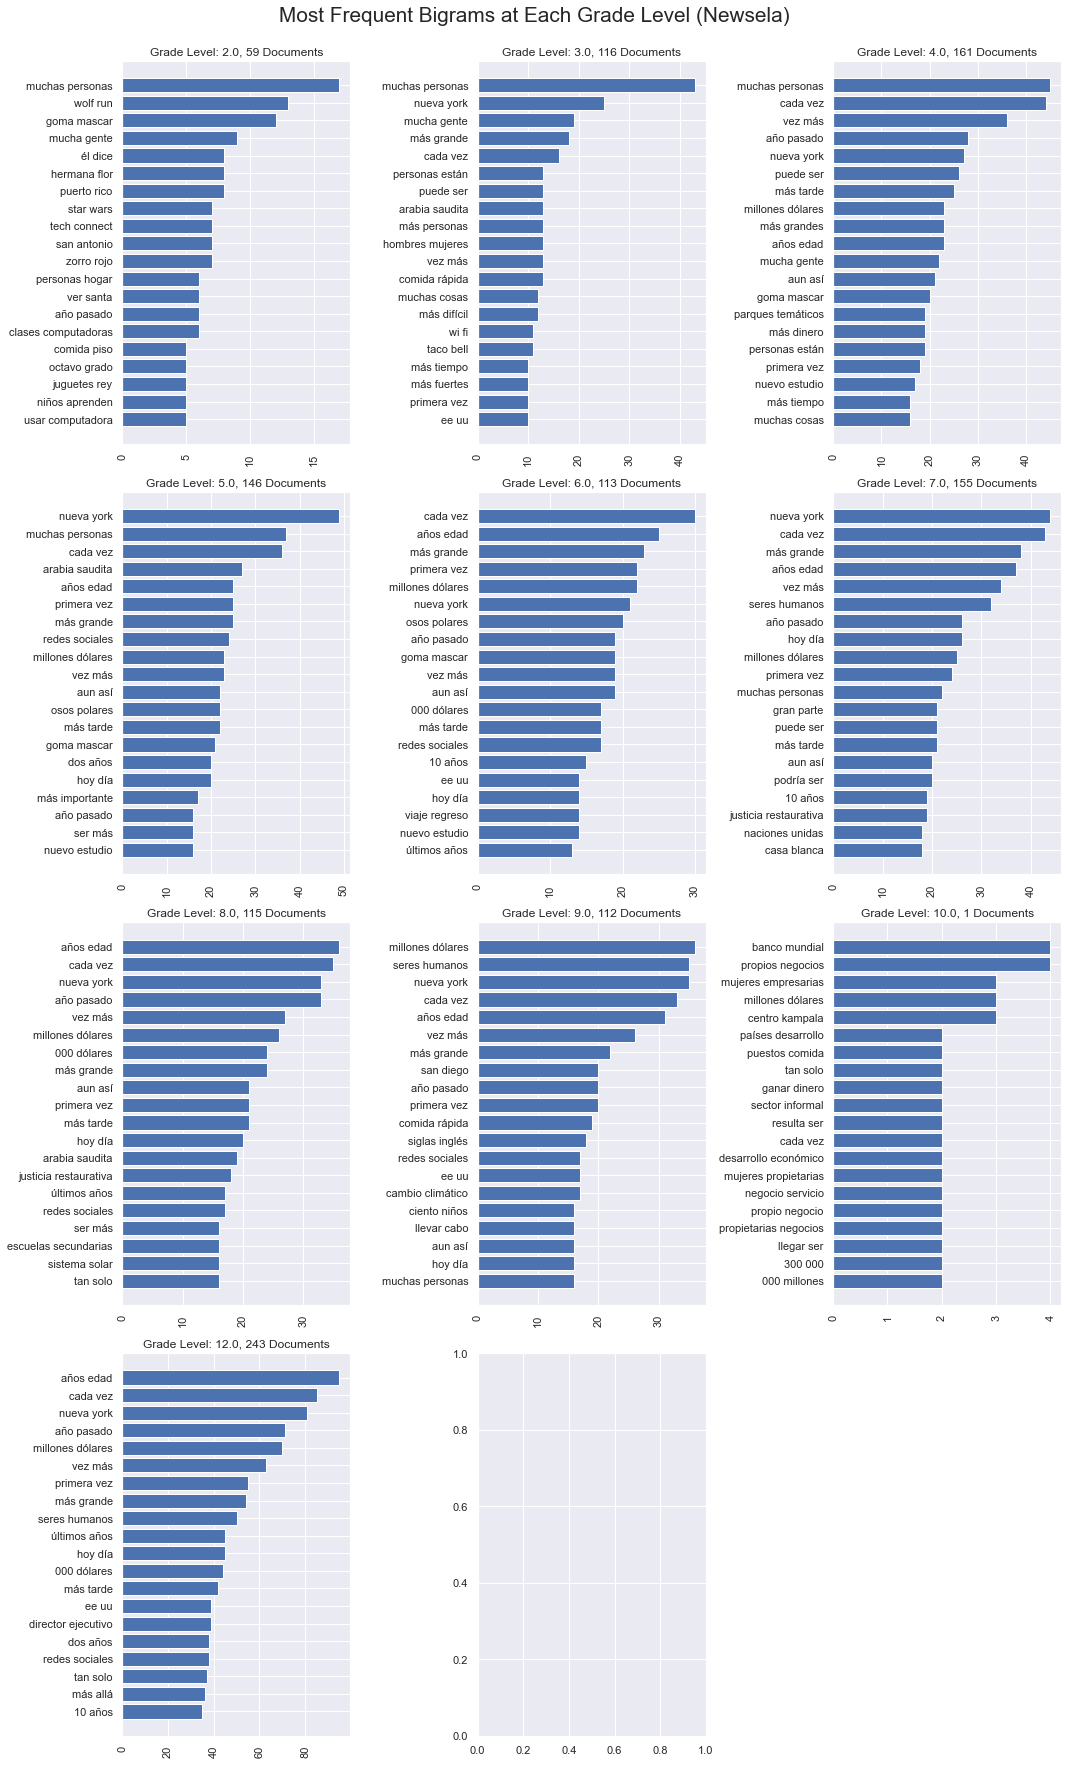

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(4,3, figsize=(15, 25))
x_counter = 0
y_counter = 0


levels = pd.unique(newsela_es['grade_level'].sort_values())

for lvl in levels:
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2,2))
    curr_level = newsela_es[newsela_es['grade_level'] == lvl]
    texts = curr_level['filename'].apply(lambda x: get_text(x, folder_path))
    counts = np.asarray(np.sum(vectorizer.fit_transform(texts), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[x_counter, y_counter].barh(keys[::-1], vals[::-1])
    axs[x_counter, y_counter].tick_params(axis='x', rotation=90)
    axs[x_counter, y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, curr_level.shape[0]))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Bigrams at Each Grade Level (Newsela)',fontsize='xx-large')
fig.delaxes(axs[3,2])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('freq_2gram_newsela.png')

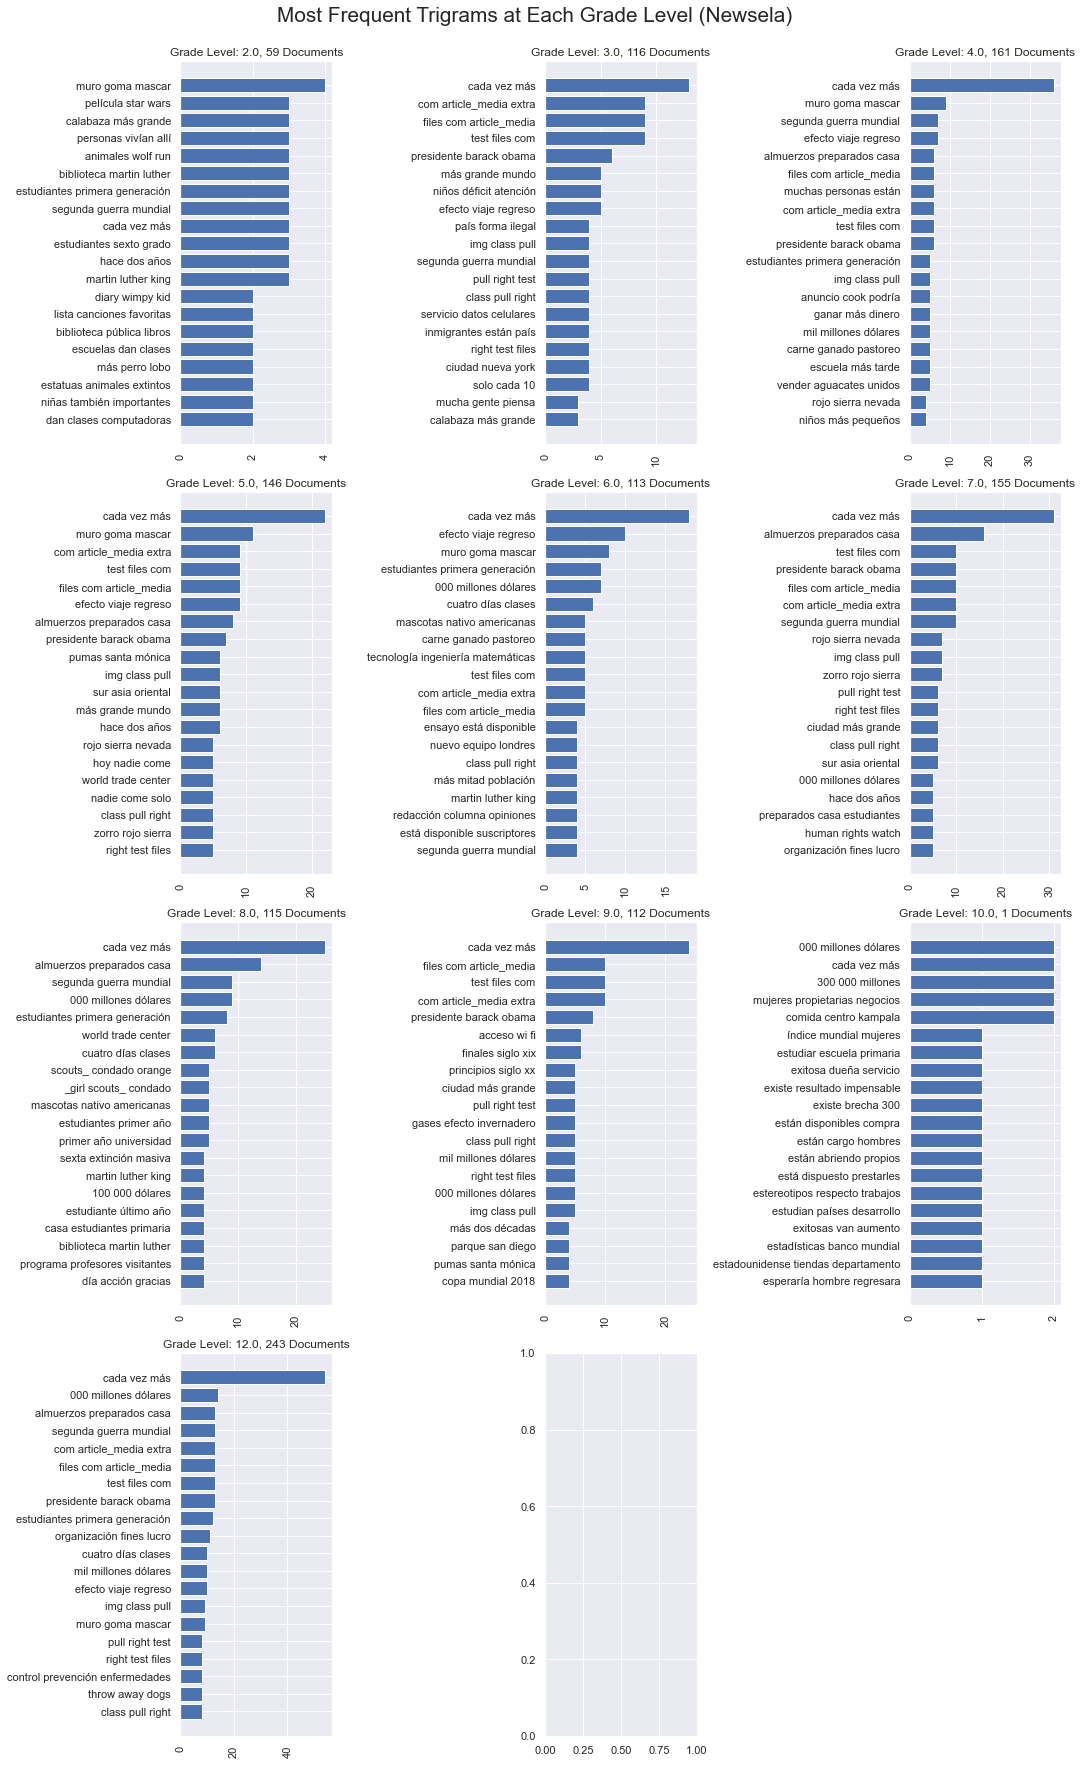

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


fig, axs = plt.subplots(4,3, figsize=(15, 25))
x_counter = 0
y_counter = 0


levels = pd.unique(newsela_es['grade_level'].sort_values())

for lvl in levels:
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(3,3))
    curr_level = newsela_es[newsela_es['grade_level'] == lvl]
    texts = curr_level['filename'].apply(lambda x: get_text(x, folder_path))
    counts = np.asarray(np.sum(vectorizer.fit_transform(texts), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[x_counter, y_counter].barh(keys[::-1], vals[::-1])
    axs[x_counter, y_counter].tick_params(axis='x', rotation=90)
    axs[x_counter, y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, curr_level.shape[0]))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Trigrams at Each Grade Level (Newsela)',fontsize='xx-large')
fig.delaxes(axs[3,2])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('freq_3gram_newsela.png')

In [37]:
output_path = os.path.join(curr_path, 'Datasets\\newsela_es_rank_features.csv')
newsela_es.to_csv(output_path, index=False)